In [1]:
import os
import sys
#!pip install node2vec
# 708 drugs, 5603 diseases, 1512 proteins, we have similarities of drugs and proteins and all labels.
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#%run gat.ipynb

In [2]:
proteins = []
drugs = []
diseases = []
proteins_txt = open("../data/protein.txt","r")
for protein in proteins_txt:
    proteins.append(protein.replace("\n",""))
proteins_txt.close()
drugs_txt = open("../data/drug.txt","r")
for drug in drugs_txt:
    drugs.append(drug.replace("\n",""))
drugs_txt.close()
diseases_txt = open("../data/disease.txt","r")
for disease in diseases_txt:
    diseases.append(disease.replace("\n",""))
diseases_txt.close()
drug_protein_matrix = np.loadtxt('../data/mat_drug_protein.txt')
drug_protein_matrix = drug_protein_matrix.astype('int64')
drug_similarities = np.loadtxt("../data/Similarity_Matrix_Drugs.txt")
protein_similarities = np.loadtxt("../data/Similarity_Matrix_Proteins.txt")
protein_drug_matrix = np.loadtxt('../data/mat_protein_drug.txt')
drug_drug_matrix = np.loadtxt('../data/mat_drug_drug.txt')
drug_disease_matrix=np.loadtxt('../data/mat_drug_disease.txt')
protein_disease_matrix=np.loadtxt('../data/mat_protein_disease.txt')
drug_feature_vector = np.loadtxt('../feature/drug_vector_d100.txt')
protein_feature_vector = np.loadtxt('../feature/protein_vector_d400.txt')

In [3]:
num_drugs = len(drugs)
num_proteins = len(proteins)

In [4]:
# Assuming drugs is a list of 1x100 vectors and proteins is a list of 1x400 vectors
# Assuming adjacency_matrix is a 708x1512 numpy array
# Flattening the adjacency matrix for easier handling
interaction_pairs = [(i, j) for i in range(len(drugs)) for j in range(len(proteins))]
interactions = [(i, j, drug_protein_matrix[i, j]) for i, j in interaction_pairs]

vector=pd.DataFrame(drug_feature_vector)
drugs = pd.DataFrame({'drug_idx': list(range(len(drugs)))})
drugs=pd.concat([drugs, vector], axis=1)

vector=pd.DataFrame(protein_feature_vector)
proteins = pd.DataFrame({'protein_idx': list(range(len(proteins)))})
proteins=pd.concat([proteins, vector], axis=1)
# Convert lists to DataFrame for easier manipulation
df = pd.DataFrame(interactions, columns=['drug_idx', 'protein_idx', 'interaction'])

# Create positive and negative samples
positive_samples = df[df['interaction'] == 1]
negative_samples = df[df['interaction'] == 0].sample(n=len(positive_samples), random_state=42)

# Combine samples
data = pd.concat([positive_samples, negative_samples])

In [5]:
data

,drug_idx,protein_idx,interaction
75,0,75,1
112,0,112,1
3170,2,146,1
3194,2,170,1
3342,2,318,1
...,...,...,...
147547,97,883,0
559811,370,371,0
571566,378,30,0
128407,84,1399,0


In [5]:
# Create feature vectors for each drug-protein pair
def create_feature_vector(drug_idx, protein_idx):
    return np.concatenate([drugs.iloc[drug_idx], proteins.iloc[protein_idx]])

# Apply the function to the dataset
data['features'] = data.apply(lambda row: create_feature_vector(row['drug_idx'], row['protein_idx']), axis=1)
X = np.vstack(data['features'].values)
y = data['interaction'].values

In [10]:
data

,drug_idx,protein_idx,interaction,features
75,0,75,1,"[0.0, -0.74688, -0.62072, -0.21067, -0.5102, 0..."
112,0,112,1,"[0.0, -0.74688, -0.62072, -0.21067, -0.5102, 0..."
3170,2,146,1,"[2.0, -0.69303, -0.57094, -0.39747, -0.27549, ..."
3194,2,170,1,"[2.0, -0.69303, -0.57094, -0.39747, -0.27549, ..."
3342,2,318,1,"[2.0, -0.69303, -0.57094, -0.39747, -0.27549, ..."
...,...,...,...,...
147547,97,883,0,"[97.0, -1.0691, -0.010676, -0.27348, 0.66106, ..."
559811,370,371,0,"[370.0, -0.60762, -0.48673, -0.044567, -0.3948..."
571566,378,30,0,"[378.0, -0.87213, -0.64867, -0.18713, -0.2407,..."
128407,84,1399,0,"[84.0, -0.85518, -0.21547, 0.22707, 0.99661, 0..."


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,RocCurveDisplay

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy: 0.83
Precision: 0.85
Recall: 0.82
F1 Score: 0.84
ROC AUC: 0.90


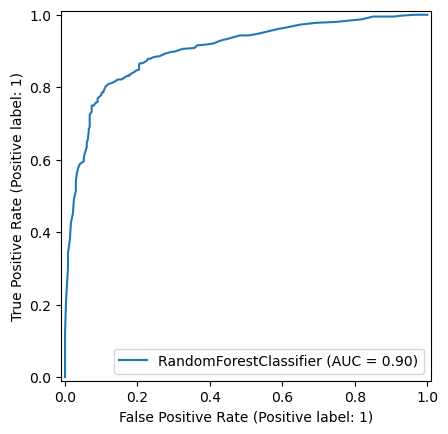

In [14]:
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [15]:
def predict_interaction(drug_idx, protein_idx):
    feature_vector = create_feature_vector(drug_idx, protein_idx).reshape(1, -1)
    return model.predict(feature_vector), model.predict_proba(feature_vector)[:, 1]

# Example: Predict interaction for drug_0 and protein_10
interaction, probability = predict_interaction(0, 10)
print(f'Interaction: {interaction[0]}, Probability: {probability[0]:.2f}')


Interaction: 1, Probability: 0.93
